In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict
import zipfile

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# with zipfile.ZipFile('oregon_wildlife.zip', 'r') as zf:
#     zf.extractall()

In [4]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path(r'C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\bald_eagle
C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\black_bear
C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\cougar
C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\deer
C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\nutria
C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\raccoon
C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\raven
C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\red_fox
C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\sea_lions
C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\virginia_opossum

total img num: 7168


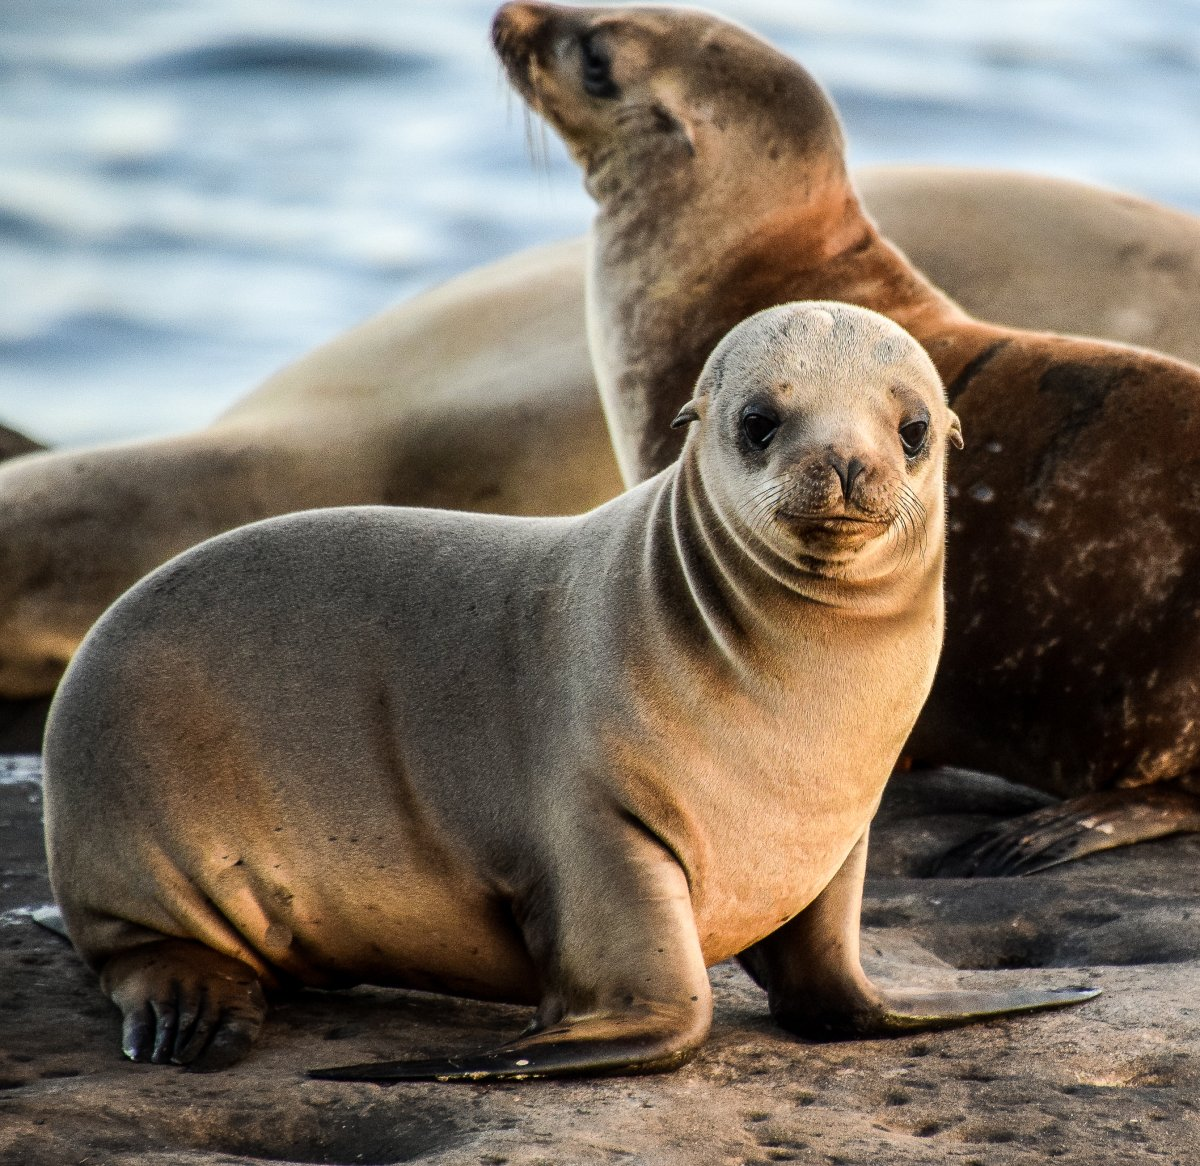

C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\sea_lions\b201c229d49b4ce8bb.jpg


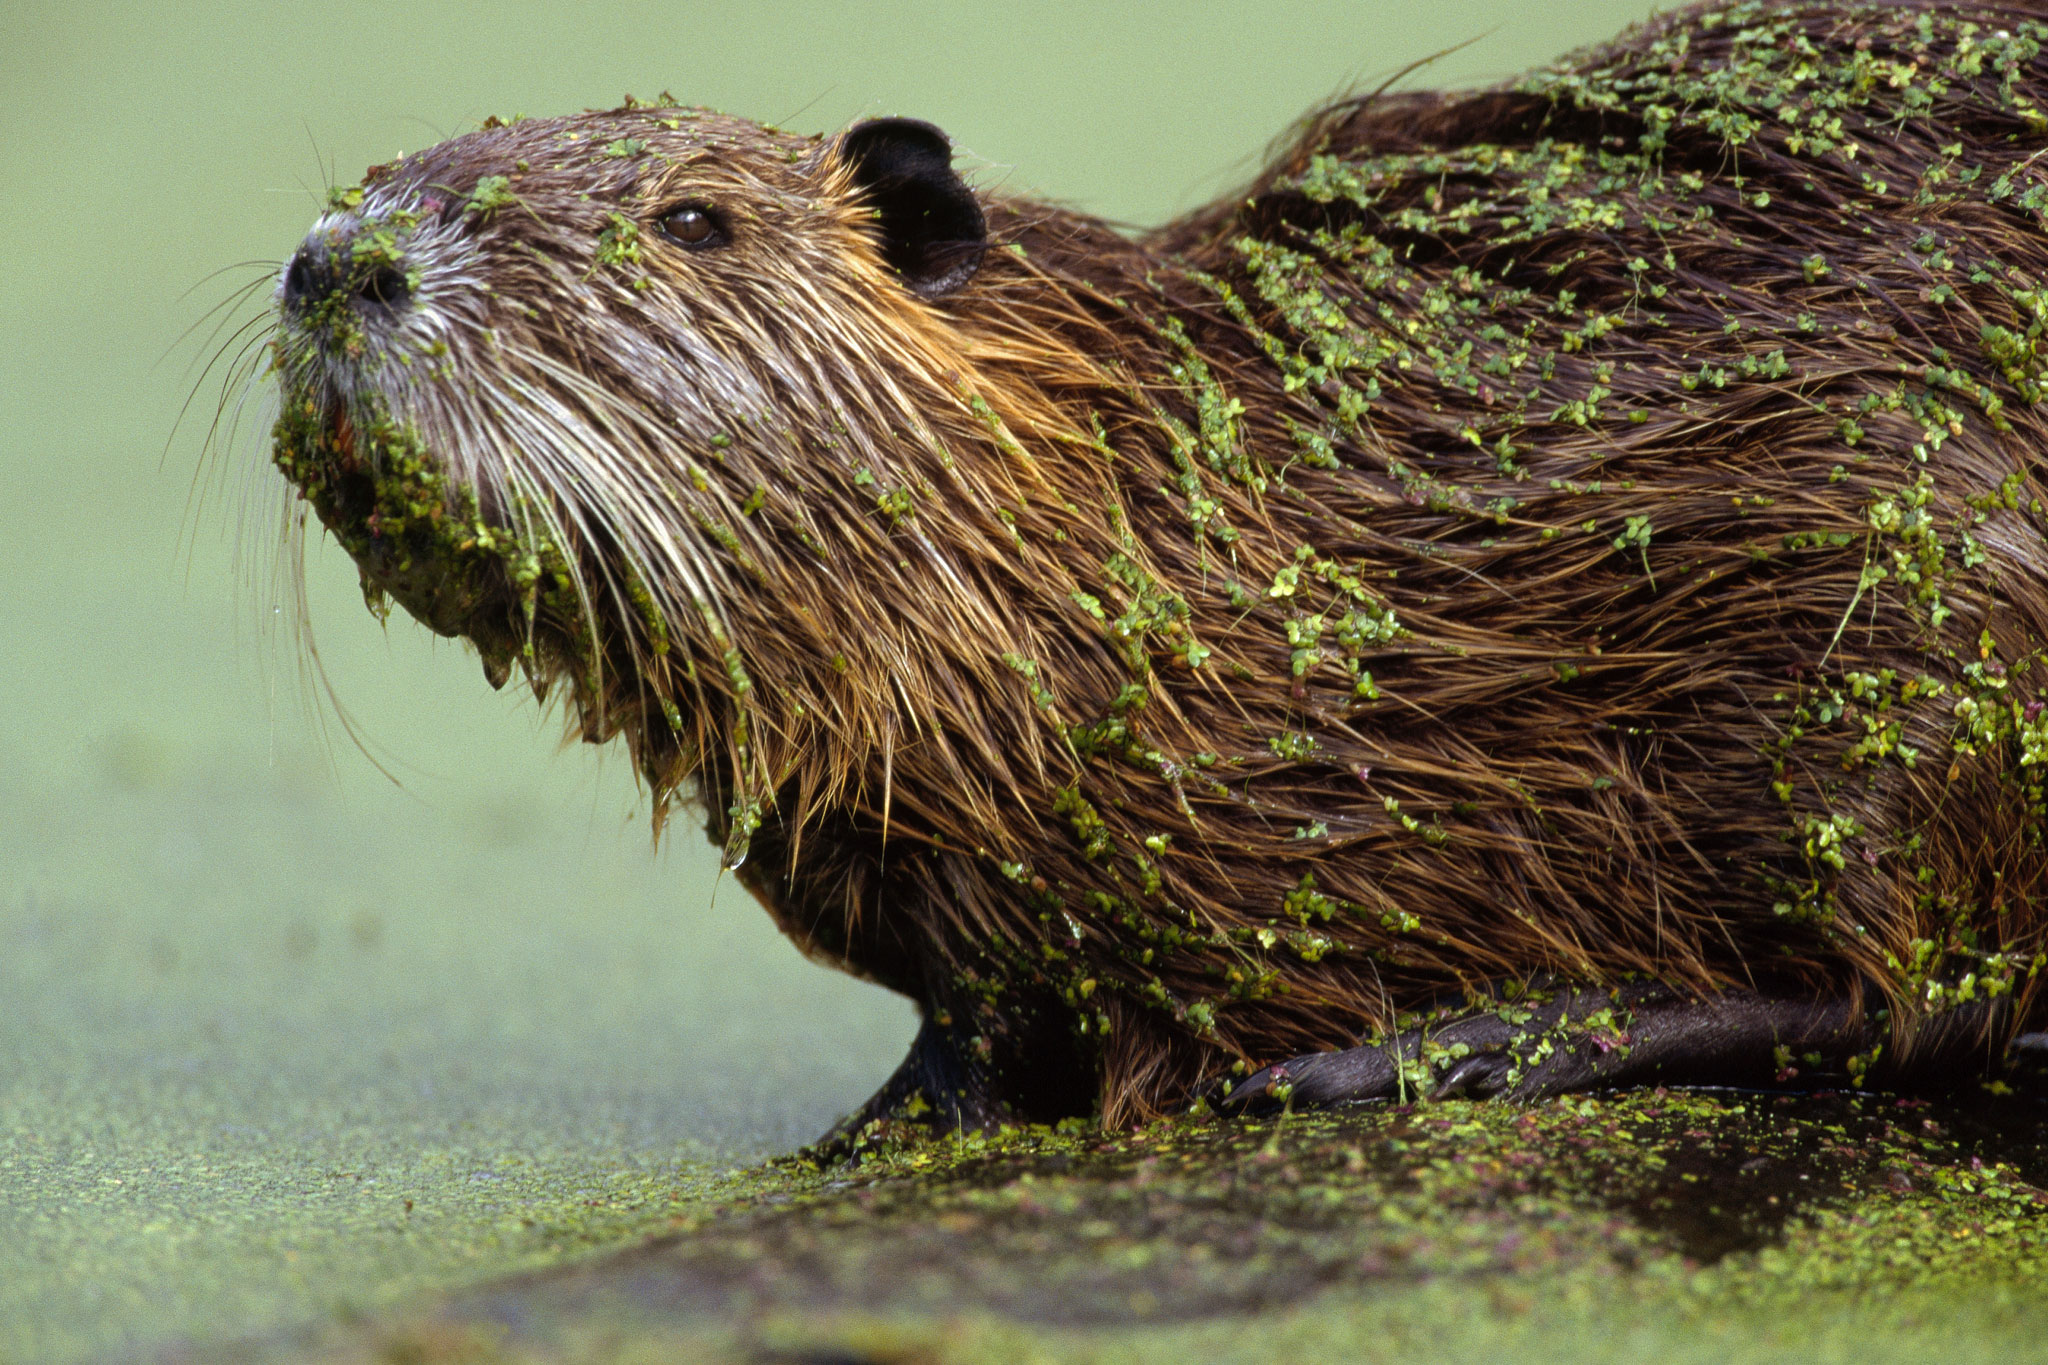

C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\nutria\514af84b8c57072a57.jpg


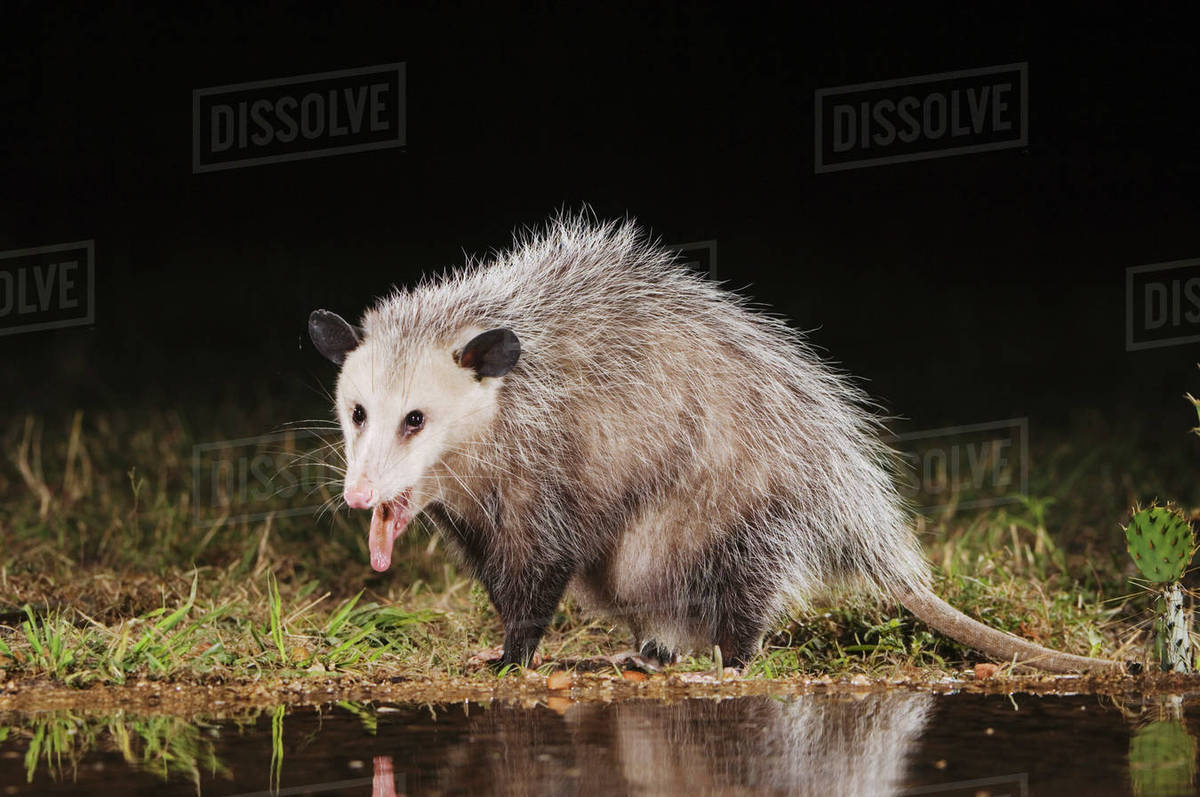

C:\Users\HMILAB\Desktop\Tony\DL_data\11-1\oregon_wildlife\virginia_opossum\b8370437d9032a6f0e.jpg


In [5]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path)

In [6]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [7]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [8]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [9]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
# img_path_train, img_path_val, label_train, label_val = img_path_train[:10], img_path_val[:10], label_train[:10], label_val[:10]
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [10]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('val.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_val, label_val):
        writer.writerow([img_path, label])

In [11]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [12]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

In [13]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string),
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32),
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )


    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        
        rows = pd.read_csv(filename.decode("utf-8"))
        img_paths = rows['img_path'].tolist()
        labels = rows['label'].tolist()
        
        open_elapsed = time.perf_counter() - open_enter

        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = load_image(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                labels[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [14]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [15]:
def dataset_generator_fun_train(*args):
    filename = 'train.csv'
    return TimeMeasuredDataset(filename)

def dataset_generator_fun_val(*args):
    return TimeMeasuredDataset('val.csv')

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_val).batch(BATCH_SIZE)

(300, 300, 3)
1.0


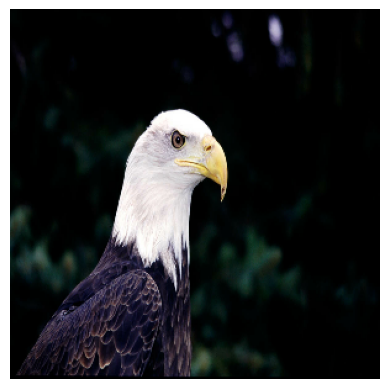

bald_eagle
(300, 300, 3)
1.0


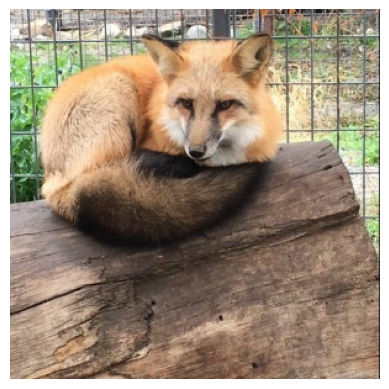

red_fox


In [16]:
for steps, timings, counters, img, label in dataset_train.take(2):
#     print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    print(np.max(img))
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [17]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [18]:
wild_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [19]:
# save the initialization of weights 
# wild_model.save_weights('wild_model.h5')

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [21]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = wild_model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def val_step(images, labels):
    predictions = wild_model(images, training=False)
    v_loss = loss_object(labels, predictions)

    val_loss(v_loss)
    val_accuracy(labels, predictions)

In [22]:
def timelined_benchmark(dataset_train, dataset_test):
    EPOCHS = 5

    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()

        print("training:")
        for steps, times, values, images, labels in tqdm(dataset_train, total=math.ceil(len(img_path_train)/BATCH_SIZE)):
            for i in range(steps.shape[0]):
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            train_enter = time.perf_counter()
            train_step(images, labels)
            train_elapsed = time.perf_counter() - train_enter

            for i in range(steps.shape[0]):        
                steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
                times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i,-1]]), axis=0)

        print("validating:")
        for steps, times, values, images, labels in tqdm(dataset_test, total=math.ceil(len(img_path_val)/BATCH_SIZE)):
            for i in range(steps.shape[0]):  
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            val_enter = time.perf_counter()
            val_step(images, labels)
            val_elapsed = time.perf_counter() - val_enter

            for i in range(steps.shape[0]):  
                steps_acc = tf.concat((steps_acc, [["Val"]]), axis=0)
                times_acc = tf.concat((times_acc, [(val_enter, val_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i,-1]]), axis=0)

        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, val Loss: {:.4f}, val Accuracy: {:.4f}'
        print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               val_loss.result(),
                               val_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch, -1]]), axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [23]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()

    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)

    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)

    order = [b'Open', b'Read', b'Map', b'Train', b'Val', b'Test', b'Epoch']
    step_ids = sorted(step_ids, key=lambda i: order.index(i))
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")

        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]

        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

# Naive training

training epoch: 5

training acc: 0.767701

validataion acc: 0.880056

Execution time: 606.7849683

In [24]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_val)

training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:40<00:00,  1.11s/it]


validating:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:26<00:00,  1.15s/it]


Epoch 1, Loss: 5.2125, Accuracy: 30.5371, val Loss: 1.1390, val Accuracy: 64.3654
training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:29<00:00,  1.01it/s]


validating:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:23<00:00,  1.03s/it]


Epoch 2, Loss: 1.0869, Accuracy: 62.5218, val Loss: 0.6687, val Accuracy: 79.1492
training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:33<00:00,  1.04s/it]


validating:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:24<00:00,  1.08s/it]


Epoch 3, Loss: 0.8012, Accuracy: 72.4799, val Loss: 0.5070, val Accuracy: 84.0307
training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:35<00:00,  1.07s/it]


validating:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.10s/it]


Epoch 4, Loss: 0.6879, Accuracy: 76.7701, val Loss: 0.5243, val Accuracy: 83.4728
training:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:40<00:00,  1.12s/it]


validating:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:26<00:00,  1.16s/it]

Epoch 5, Loss: 0.6760, Accuracy: 76.7701, val Loss: 0.3986, val Accuracy: 88.0056
Execution time: 606.7849683


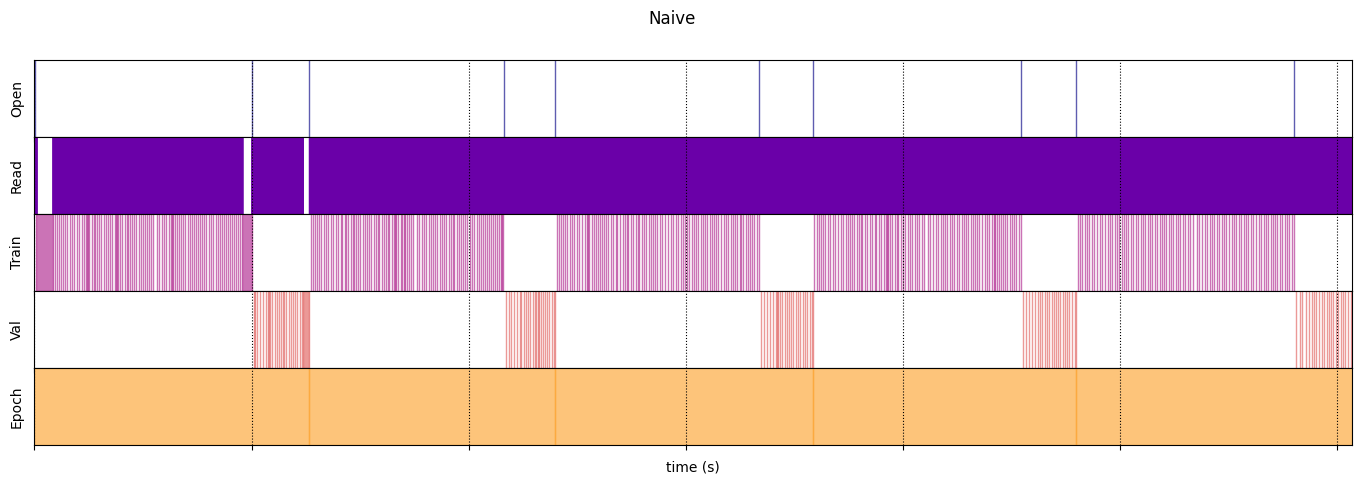

In [25]:
draw_timeline(timeline_Naive, "Naive", 500)

In [26]:
## TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
## Remember to define your own map functions before calling map

# dataset_train_augmentation = tf.data.Dataset.range(1). ...
# dataset_train_augmentation = tf.data.Dataset.range(1). ...

In [27]:

# feel free to modify these two Settings.
# BUFFER_SIZE = 10000
# BATCH_SIZE = 1

# read data
def unpickle(file):
    with open(file, 'rb') as fo:
        raw_data = pickle.load(fo, encoding='bytes')
    return raw_data[b'data'],raw_data[b'labels']

# parse training data
@tf.function
def map_fun(steps, times, values, image, label):
    map_enter = time.perf_counter()
    
#     image = tf.reshape(image,[tf.shape(image)[0], IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
#     image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    distorted_image = tf.image.resize(distorted_image, [300,300])
#     distorted_image = (distorted_image-tf.reduce_min(distorted_image)) / (tf.reduce_max(distorted_image)-tf.reduce_min(distorted_image))
    map_elapsed = time.perf_counter() - map_enter
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

# parse testing data
def map_fun_test(steps, times, values, image, label):
    map_enter = time.perf_counter()
    
#     image = tf.reshape(image,[tf.shape(image)[0],IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
#     image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    distorted_image = tf.image.resize(distorted_image, [300,300])

    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

In [28]:
def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv')

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('val.csv')

dataset_train_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                        .shuffle(BUFFER_SIZE)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .map(map_fun)

dataset_test_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test)\
                                       .batch(BATCH_SIZE, drop_remainder=True)\
                                       .map(map_fun_test)                   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
5.3137164 -4.0318313


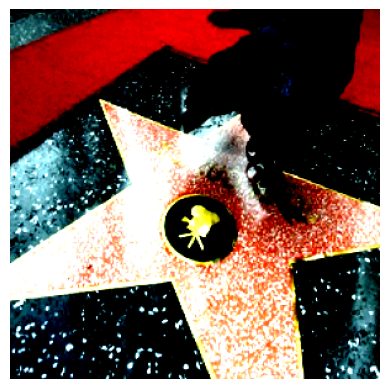

raven


In [29]:
# for steps, timings, counters, img, label in dataset_train_augmentation.take(1):
#     # print(steps[0], timings[0], counters[0])
#     print(img[0].shape)
#     print(type(img))
#     z=np.max(img)
#     print(np.max(img), np.min(img))
#     plt.imshow(img[0]) 
#     plt.axis('off') 
#     plt.show()
#     print(index_to_label[label[0].numpy()])

# Training with image augmentation

training epoch: 5

other training hypermeters are same to naive training

augmentation的方法：
1. random_crop
2. random_flip_left_right
3. image.random_brightness
4. random_contrast
5. per_image_standardization

training acc: 0.8244

validataion acc: 0.9105

Execution time: 741.2665014

**因為有image augmentation，所以excution time會比naive training還要久，但training acc與validation acc均比naive training還要高**


In [30]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation)

training:


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 89/90 [01:53<00:01,  1.28s/it]


validating:


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 22/23 [00:25<00:01,  1.14s/it]


Epoch 1, Loss: 7.0263, Accuracy: 42.5211, val Loss: 0.7483, val Accuracy: 78.5511
training:


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 89/90 [01:56<00:01,  1.31s/it]


validating:


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 22/23 [00:26<00:01,  1.20s/it]


Epoch 2, Loss: 0.9479, Accuracy: 67.6088, val Loss: 0.5462, val Accuracy: 84.3040
training:


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 89/90 [02:00<00:01,  1.36s/it]


validating:


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 22/23 [00:27<00:01,  1.23s/it]


Epoch 3, Loss: 0.7392, Accuracy: 75.4565, val Loss: 0.3994, val Accuracy: 87.9261
training:


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 89/90 [02:05<00:01,  1.41s/it]


validating:


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 22/23 [00:28<00:01,  1.29s/it]


Epoch 4, Loss: 0.5939, Accuracy: 81.0569, val Loss: 0.3269, val Accuracy: 90.1989
training:


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 89/90 [02:08<00:01,  1.45s/it]


validating:


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 22/23 [00:28<00:01,  1.31s/it]

Epoch 5, Loss: 0.5380, Accuracy: 82.4438, val Loss: 0.3088, val Accuracy: 91.0511
Execution time: 741.2665014


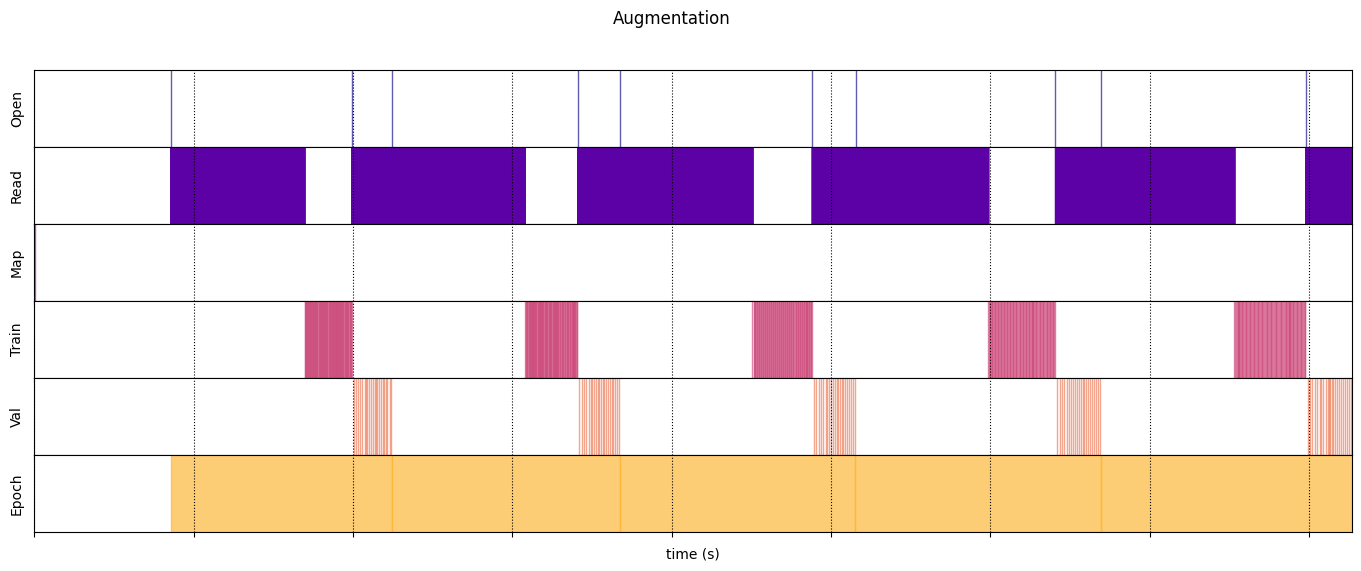

In [31]:
draw_timeline(timeline_Augmentation, "Augmentation", 500)

In [32]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated

# dataset_train_optimized = tf.data.Dataset.range(1). ...
# dataset_test_optimized = tf.data.Dataset.range(1). ...

In [33]:
dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_fun, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)
dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .batch(BATCH_SIZE, drop_remainder=True)\
                                                 .map(map_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .cache()\
                                                 .prefetch(tf.data.AUTOTUNE)

# Training with image augmentation and optimization

training epoch: 5

other training hypermeters are same to naive training

augmentation的方法：
1. random_crop
2. random_flip_left_right
3. random_brightness
4. random_contrast
5. per_image_standardization

optimization的方法：
1. Interleave
2. Parallel mapping
3. Caching
4. prefetching

training acc: 0.892556

validataion acc: 0.884943

Execution time: 252.87296060000017

**因為有optimizaion，因此即使有做image augmentation，excution time也比naive training與trainging with augmentation還要快，且快很多。而且training acc與validation acc與training augmentation的結果差不多。**

excution time可以縮短，有部分原因是利用Parallel mapping，使augmentation的時間縮短。
可以看到除了train與val之外，Read的時間也少很多，推測是因為有利用interleave與caching的關係。

In [34]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized)

training:


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 89/90 [01:42<00:01,  1.15s/it]


validating:


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 22/23 [00:20<00:00,  1.05it/s]


Epoch 1, Loss: 7.2644, Accuracy: 37.0962, val Loss: 0.8081, val Accuracy: 74.7159
training:


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 89/90 [00:19<00:00,  4.57it/s]


validating:


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 22/23 [00:05<00:00,  4.17it/s]


Epoch 2, Loss: 0.8791, Accuracy: 69.3645, val Loss: 0.5260, val Accuracy: 82.1733
training:


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 89/90 [00:23<00:00,  3.78it/s]


validating:


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 22/23 [00:05<00:00,  3.70it/s]


Epoch 3, Loss: 0.5721, Accuracy: 80.8462, val Loss: 0.3947, val Accuracy: 86.2926
training:


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 89/90 [00:28<00:00,  3.14it/s]


validating:


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 22/23 [00:07<00:00,  3.01it/s]


Epoch 4, Loss: 0.4053, Accuracy: 86.3588, val Loss: 0.3761, val Accuracy: 87.4290
training:


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 89/90 [00:31<00:00,  2.84it/s]


validating:


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 22/23 [00:07<00:00,  2.82it/s]

Epoch 5, Loss: 0.3196, Accuracy: 89.2556, val Loss: 0.3533, val Accuracy: 88.4943
Execution time: 252.87296060000017


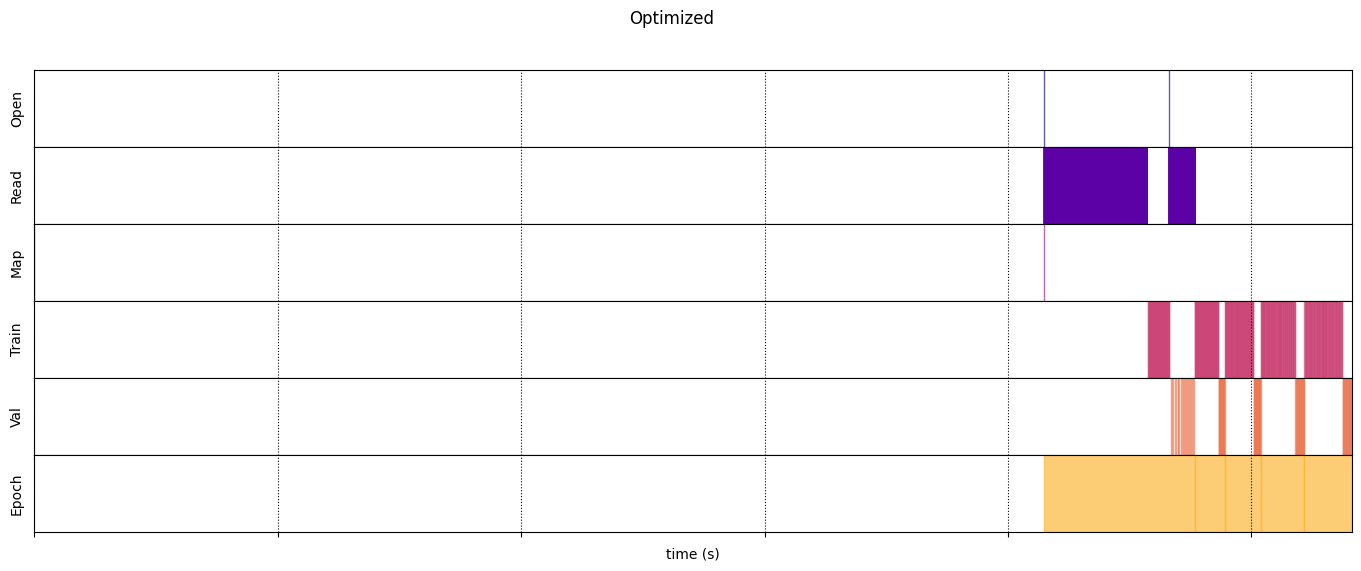

In [35]:
draw_timeline(timeline_Optimized, "Optimized", 500)